In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
model = YOLO("yolov8m-seg.pt")
results = model.predict("cat_dog.jpg")


image 1/1 d:\YoloV8\Product_Segmentation_YoloV8\research\cat_dog.jpg: 384x640 1 cat, 2 dogs, 3872.0ms
Speed: 92.7ms preprocess, 3872.0ms inference, 388.8ms postprocess per image at shape (1, 3, 384, 640)


In [3]:
image = Image.open("cat_dog.jpg")

In [4]:
result = results[0]
print(f'Results: {result}')


Results: ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 5

In [5]:
len(result.masks)

3

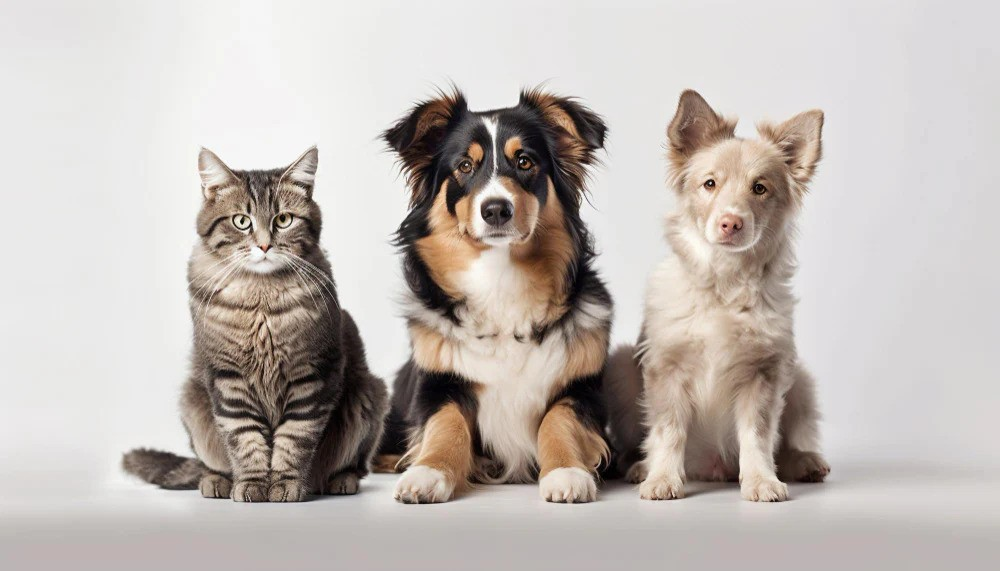

In [7]:
Image.open(result.path)

In [10]:
image = cv2.imread(result.path)
image.shape

(571, 1000, 3)

In [15]:
masks = result.masks
masks.shape

torch.Size([3, 384, 640])

In [25]:
mask = masks[1].data[0].numpy()
mask.shape

(384, 640)

In [26]:
segmentation_mask = mask

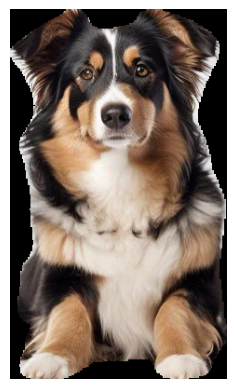

In [27]:
# Resize segmentation_mask to match the shape of the image if necessary
segmentation_mask_resized = cv2.resize(segmentation_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Create the binary mask (ensure it's single channel)
binary_mask = (segmentation_mask_resized > 0.5).astype(np.uint8)

# Use the binary mask to extract the segmented region from the image
segmented_region = cv2.bitwise_and(image, image, mask=binary_mask)

# Find contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the bounding box of the largest contour (assumes one main object in mask)
if len(contours) > 0:
    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the segmented region using the bounding box
    cropped_segmented_region = segmented_region[y:y+h, x:x+w]

    # Create an alpha channel based on the binary mask
    alpha_channel = binary_mask[y:y+h, x:x+w] * 255

    # Combine the cropped segmented region with the alpha channel
    cropped_segmented_region_with_alpha = np.dstack((cropped_segmented_region, alpha_channel))

    # Display the cropped segmented region with alpha channel
    plt.imshow(cv2.cvtColor(cropped_segmented_region_with_alpha, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.show()

    # Save the cropped segmented region if needed
    cv2.imwrite('segmented_region_only.png',  cropped_segmented_region_with_alpha)
else:
    print("No contours found in the segmentation mask.")

In [42]:
for i, result in enumerate(results):
    image = cv2.imread(result.path)
    masks = result.masks
    for j, mask in enumerate(masks):
        mask = mask.data[0].numpy()
        segmentation_mask = mask
        segmentation_mask_resized = cv2.resize(segmentation_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        binary_mask = (segmentation_mask_resized > 0.5).astype(np.uint8)
        segmented_region = cv2.bitwise_and(image, image, mask=binary_mask)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            cropped_segmented_region = segmented_region[y:y+h, x:x+w]
            alpha_channel = binary_mask[y:y+h, x:x+w] * 255
            cropped_segmented_region_with_alpha = np.dstack((cropped_segmented_region, alpha_channel))
            cv2.imwrite(f'dumpImage/segmented_region_only_{i}_{j}.jpg',  cropped_segmented_region_with_alpha)